The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset 

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

In [97]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [98]:
df.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1


# Data exploration

In [99]:
df.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,36861.000000,33706.000000,33708.000000,33264.000000,31114.000000,2203.000000,565.000000,39723.000000,41396.000000
mean,6.039527,3.094612,3.319212,2.805886,2.392364,2.736723,2.249558,3.164111,0.533820
std,3.214680,1.405515,1.541307,1.580246,1.704753,1.569073,1.541283,1.523486,0.498861
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [100]:
df.isnull().sum()

airline_name                         0
link                                 0
title                                0
author                               0
author_country                    1591
date                                 0
content                              0
aircraft                         40118
type_traveller                   39018
cabin_flown                       2876
route                            39055
overall_rating                    4535
seat_comfort_rating               7690
cabin_staff_rating                7688
food_beverages_rating             8132
inflight_entertainment_rating    10282
ground_service_rating            39193
wifi_connectivity_rating         40831
value_money_rating                1673
recommended                          0
dtype: int64

* From this descriptive table, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. 
* It is noticeable that data for overall rating, recommended and value_money rating are nearly full while rating data for ground service and wifi connectivity are mostly missing.However, we should not assume that it is becaus travellers tend to pay more attention to these rating when they score and leave out other ratings or because some airlines simply don't provide these amenities in some routes. Hence, I think it's more logical to replace those missing values by 0 than by imputed values(mean, median). 
* The data points with missing values for overall rating will be deleted as it is our main concern. 

In [101]:
df.dtypes

airline_name                      object
link                              object
title                             object
author                            object
author_country                    object
date                              object
content                           object
aircraft                          object
type_traveller                    object
cabin_flown                       object
route                             object
overall_rating                   float64
seat_comfort_rating              float64
cabin_staff_rating               float64
food_beverages_rating            float64
inflight_entertainment_rating    float64
ground_service_rating            float64
wifi_connectivity_rating         float64
value_money_rating               float64
recommended                        int64
dtype: object

* we will need to change some categorical features above into category type. Date into date type, but we may not need it in this model

In [102]:
df.groupby('type_traveller').size()

type_traveller
Business          362
Couple Leisure    601
FamilyLeisure     611
Solo Leisure      804
dtype: int64

* This shows that we have lots of missing data for type of travellers

In [103]:
df.groupby('cabin_flown').size()

cabin_flown
Business Class      6347
Economy            29784
First Class          879
Premium Economy     1510
dtype: int64

* Those missing points in this case are not many, so we just replace with 0 for missing values

In [104]:
len(df['airline_name'].unique()) #how many airlines operate

362

In [105]:
len(df['author_country'].unique()) #to see whether the reviews come from just some countries

159

In [106]:
len(df['aircraft'].unique()) #how many types of aircraft

364

In [107]:
len(df['route'].unique()) #how many routes

2209

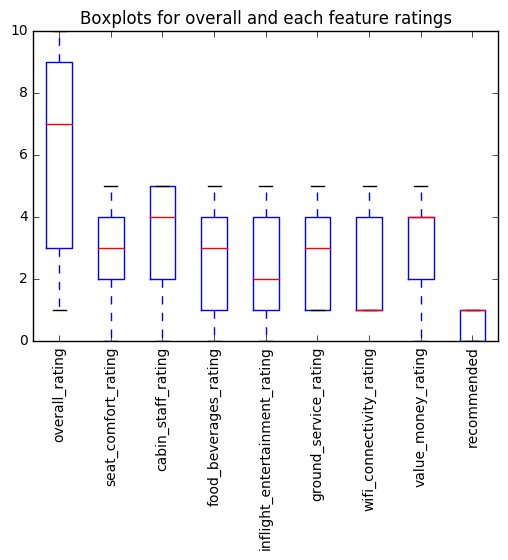

In [108]:
df.plot.box()
plt.xticks(rotation='vertical')
plt.title('Boxplots for overall and each feature ratings')
plt.show()

* the boxplot may not be useful yet because of many missing values and denoted as 0 in our data

# Data wrangling

In [109]:
#get rid of data points without overall rating
df_clean=df[df['overall_rating'].notnull()]

In [110]:
#'link','title','author','author_country','date','content','aircraft','route'
df_clean.drop(['link','title','author','author_country','date','content','aircraft','route'],axis=1, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [111]:
df_clean.head()

,airline_name,type_traveller,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,NaN,Economy,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,NaN,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,NaN,Economy,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1
3,adria-airways,NaN,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1
4,adria-airways,NaN,Economy,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0


In [112]:
#deal with missing values
df_clean=df_clean.fillna({'ground_service_rating':0, 'wifi_connectivity_rating':0,'seat_comfort_rating':0,'cabin_staff_rating':0,'food_beverages_rating':0,'inflight_entertainment_rating':0, 'value_money_rating':0}, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [113]:
#replace missing value of categorical variables with their mode
#df_clean=df_clean.fillna(df_clean.mode().iloc[0])


In [114]:
#change types of columns traveller types, recommended and cabin flown into category type
df_traveller= pd.get_dummies(df_clean['type_traveller'])
df_cabin_flown= pd.get_dummies(df_clean['cabin_flown'])
df_clean=pd.concat([df_clean, df_traveller, df_cabin_flown], axis=1)
df_clean.drop(['type_traveller','cabin_flown'], axis=1, inplace=True)

In [115]:
df_clean.isnull().values.any() #check if there are any missing values in dataframe

False

In [116]:
df_clean.head()

,airline_name,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,Business,Couple Leisure,FamilyLeisure,Solo Leisure,Business Class,Economy,First Class,Premium Economy
0,adria-airways,7.0,4.0,4.0,4.0,0.0,0.0,0.0,4.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,adria-airways,10.0,4.0,5.0,4.0,1.0,0.0,0.0,5.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,adria-airways,9.0,5.0,5.0,4.0,0.0,0.0,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,adria-airways,8.0,4.0,4.0,3.0,1.0,0.0,0.0,4.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,adria-airways,4.0,4.0,2.0,1.0,2.0,0.0,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [117]:
df_clean.shape

(36861, 18)

# Modelling

#### Ridge regression

In [118]:
y=df_clean.overall_rating
X=df_clean.drop(['overall_rating','airline_name'], axis=1)

In [120]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=1)

In [155]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
ridge_model=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5).fit(Xlr,ylr)
model=SelectFromModel(ridge_model, prefit=True)
model_new=model.transform(Xlr)
model_new.shape


(27645, 7)

In [152]:
#RSS_ridge=sum((ridge_model.predict(Xlr)-ylr)**2)
print('alpha=', ridge_model.alpha_)
print('R^2 score: ',ridge_model.score(Xlr,ylr))

alpha= 0.1
R^2 score:  0.797751283969


In [153]:
RSS_ridge=sum((ridge_model.predict(Xtestlr)-ytestlr)**2)
print('R^2 on test set: ',ridge_model.score(Xtestlr,ytestlr))

R^2 on test set:  0.804197048726


#### Random forest

In [125]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=200, random_state=1, max_features=8)
forest.fit(Xlr,ylr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

Feature ranking:
1. feature 7 (0.522277)
2. feature 6 (0.270990)
3. feature 1 (0.086915)
4. feature 0 (0.056448)
5. feature 2 (0.027987)
6. feature 3 (0.018815)
7. feature 13 (0.003871)
8. feature 12 (0.003211)
9. feature 4 (0.002384)
10. feature 14 (0.001614)
11. feature 15 (0.001597)
12. feature 11 (0.001142)
13. feature 5 (0.000907)
14. feature 10 (0.000624)
15. feature 9 (0.000623)
16. feature 8 (0.000596)


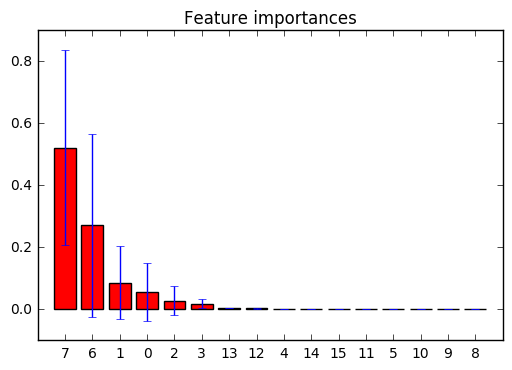

In [132]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

* So value-money rating and wifi connectivity are most important features that may affect overall rating

In [149]:
results = model_selection.cross_val_score(forest, Xlr, ylr, cv=5)
print('R^2 on train set', results.mean())

R^2 on train set 0.844871735854


In [137]:
print('R^2 on test set:',forest.score(Xtestlr,ytestlr))

R^2 on test set: 0.851120141861
